In [1]:
#Setup packages etc
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pickle
import bz2
import itertools
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from tools.detector import Detector
from tools.readpandas import Get_Momentum

#from trackml.dataset import load_event, load_dataset
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.models import load_model
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#############################################################
###                                                       ###
###           my functions                                ### 
############################################################
#convert truth direction to local coordinate frame, used to prepare training data
detector = Detector('/Users/pjfox/Dropbox/NN/TrackML/detectors.csv')

def truthmom_to_uvw(a):
    b = detector.GlobalToLocalMom(a[1], a[2], a[3], volid, a[4], a[5])
    norm = np.linalg.norm(b)
    return [b[0], b[1], b[2]]/norm


######################
## given a NN predict the directions
#######################
def my_norm(x):
    return (x/np.linalg.norm(x))

def predicteddirections(NNmodel, data):
    temp = NNmodel.predict(data)
    temp = np.apply_along_axis(my_norm,1,temp)
    return temp

##################
### plot an individual hit (jj = 0,1 for two choices of where to start vector arrows--head or tail)
###################
def plot_a_hit(hit_to_plot, NNmodel,jj):
    lw=1
    hitpattern = hit_to_plot[-8:]
    print(hitpattern)
    truedirection = truthmom_to_uvw(hit_to_plot)
    predicteddirection = predicteddirections(NNmodel, np.reshape(hitpattern,(1,8)))[0]
    print(predicteddirection)
    xs=np.array([hitpattern[0],hitpattern[3]])  #x vals of hit
    ys=np.array([hitpattern[1],hitpattern[4]]) #y vals of hit
    ss = np.array([50*hitpattern[2]/(hitpattern[2] + hitpattern[5]),50*hitpattern[5]/(hitpattern[2] + hitpattern[5])])
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(xs, ys, s=ss)
    line=matplotlib.lines.Line2D([xs[0],xs[0]+truedirection[0]],[ys[0],ys[0]+truedirection[1]])
    ax.add_line(line)
    veclength = 1*np.sqrt((xs.max() - xs.min())**2 + (ys.max() - ys.min())**2)
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_zlim([-10,10])
    ax.quiver(xs[jj], ys[jj], 0, truedirection[0], truedirection[1], truedirection[2], length=veclength, normalize=True, color='g',linewidth=lw)
    ax.quiver(xs[jj], ys[jj], 0, predicteddirection[0], predicteddirection[1], predicteddirection[2], length=veclength, normalize=True, color='r',linestyle="--",linewidth=lw)
    ax.scatter(xs, ys, np.zeros(2), s=ss)
    fig.show()
    print("vetors (true, predicted)\n", truedirection,"\n", predicteddirection)
    print("cosine of angle between = ",csine,"   angle = ", np.arccos(csine)*180/np.pi," degrees")
    return

Using TensorFlow backend.


In [4]:
event = pd.read_pickle("/Users/pjfox/Dropbox/NN/TrackML/from_squirrel/events10.pkl",compression="bz2")

In [3]:
event

,event_id,hit_id,particle_id,x,y,z,tpx,tpy,tpz,volume_id,layer_id,module_id,ch0_i,ch1_i,charge_i,ch0_f,ch1_f,charge_f,nch0,nch1
0,1000,1,0,-64.409897,-7.163700,-1502.5,250710.000000,-149908.000000,-956385.000000,7,2,1,209,618,0.211723,210,617,0.079887,2,2
1,1000,2,22525763437723648,-55.336102,0.635342,-1502.5,-0.570605,0.028390,-15.492200,7,2,1,68,446,0.334087,68,446,0.334087,1,1
2,1000,3,0,-83.830498,-1.143010,-1502.5,626295.000000,-169767.000000,-760877.000000,7,2,1,60,951,0.019897,58,956,0.007798,3,6
3,1000,4,297237712845406208,-96.109100,-8.241030,-1502.5,-0.225235,-0.050968,-3.702320,7,2,1,181,1181,0.323907,181,1181,0.323907,1,1
4,1000,5,418835796137607168,-62.673599,-9.371200,-1502.5,-0.281806,-0.023487,-6.573180,7,2,1,256,590,0.296566,256,590,0.296566,1,1
5,1000,6,108087696726949888,-57.068699,-8.177770,-1502.5,-0.401129,-0.035276,-10.466900,7,2,1,241,489,0.289269,241,489,0.289269,1,1
6,1000,7,968286151951515648,-73.872299,-2.578900,-1502.5,-0.442662,-0.036969,-9.130100,7,2,1,103,779,0.304021,103,779,0.304021,1,1
7,1000,8,954766419537428480,-63.853500,-10.868400,-1502.5,-0.670459,-0.092609,-15.540700,7,2,1,284,613,0.287819,284,613,0.287819,1,1
8,1000,9,707072769359085568,-97.254799,-10.889100,-1502.5,-0.279789,-0.062143,-4.412920,7,2,1,232,1205,0.329157,232,1205,0.329157,1,1
9,1000,10,67554956483231744,-90.292900,-3.269370,-1502.5,-0.251752,-0.037138,-4.249220,7,2,1,91,1070,0.003647,91,1071,0.236652,1,2


In [8]:
detector.GlobalToLocalMomBatch(event[:10])

array([[ 1.69116315e+05, -2.38175414e+05,  9.56385000e+05],
       [-7.30720257e-02,  5.66618320e-01,  1.54921999e+01],
       [ 2.18382150e+05, -6.11044366e+05,  7.60877000e+05],
       [ 3.31395301e-02,  2.28539536e-01,  3.70232010e+00],
       [ 1.30434486e-03,  2.82779953e-01,  6.57318020e+00],
       [ 3.69502265e-03,  4.02660050e-01,  1.04668999e+01],
       [ 2.12376364e-03,  4.44197797e-01,  9.13010025e+00],
       [ 3.97196815e-02,  6.75657951e-01,  1.55407000e+01],
       [ 3.99998190e-02,  2.83802127e-01,  4.41292000e+00],
       [ 1.72713695e-02,  2.53889660e-01,  4.24921989e+00]])

In [9]:
detector.GlobalToLocalMomBatchNorm(event[:10])

array([[ 1.69116304e-01, -2.38175400e-01,  9.56384941e-01],
       [-4.71349390e-03,  3.65495820e-02,  9.99320725e-01],
       [ 2.18382173e-01, -6.11044430e-01,  7.60877080e-01],
       [ 8.93365542e-03,  6.16090045e-02,  9.98060379e-01],
       [ 1.98250993e-04,  4.29805095e-02,  9.99075891e-01],
       [ 3.52758822e-04,  3.84414111e-02,  9.99260794e-01],
       [ 2.32336391e-04,  4.85945380e-02,  9.98818561e-01],
       [ 2.55342848e-03,  4.34355006e-02,  9.99052970e-01],
       [ 9.04519511e-03,  6.41764306e-02,  9.97897575e-01],
       [ 4.05732832e-03,  5.96428505e-02,  9.98211535e-01]])

In [6]:
dir(detector)

['GlobalToLocal',
 'GlobalToLocalBatch',
 'GlobalToLocalMom',
 'GlobalToLocalMomBatch',
 'GlobalToLocalMomBatchNorm',
 'HitsToImage',
 'LocalToGlobal',
 'LocalToGlobalBatch',
 'LocalToGlobalMom',
 'LocalToGobalMomBatch',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_calc_hu',
 '_load_element_info',
 '_position',
 '_positon_inv',
 'detector']

In [4]:
event.columns

Index(['event_id', 'hit_id', 'particle_id', 'x', 'y', 'z', 'tpx', 'tpy', 'tpz',
       'volume_id', 'layer_id', 'module_id', 'ch0_i', 'ch1_i', 'charge_i',
       'ch0_f', 'ch1_f', 'charge_f', 'nch0', 'nch1'],
      dtype='object')

In [6]:
# select some good hits in a particular volume 
volid=8
goodhits=event.loc[event['particle_id'] != 0]
#selectedhits = goodhits.loc[goodhits['volume_id'] == volid][['hit_id','tpx','tpy','tpz', 'layer_id', 'module_id','ch0_i','ch1_i','charge_i','ch0_f','ch1_f','charge_f', 'nch0', 'nch1']].values
#^^^^^for cluster analysis
selectedhits = goodhits.loc[goodhits['volume_id'] == volid][['hit_id','tpx','tpy','tpz', 'layer_id', 'module_id','x','y','z']].values
#^^^^^^for x, y, z analysis
print(selectedhits.shape)

(252694, 9)


In [7]:
#make training data
selectedhits2 = selectedhits#[:100000,]

#for cluster analysis
#x = selectedhits2[:,-8:] 
#y = detector.GlobalToLocalMomBatchNorm(goodhits[goodhits['volume_id'] == volid])

#for x, y, z analysis
y = detector.GlobalToLocalMomBatchNorm(goodhits[goodhits['volume_id'] == volid])
x = selectedhits2[:,-3:]  
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.4, random_state=67)

NameError: name 'detector' is not defined

In [ ]:
# 2 NN's one uses cosine_proximity one uses mean square error
NNmodel_CP = Sequential()
NNmodel_CP.add(Dense(units=x_train.shape[1], input_dim=x_train.shape[1]))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=x_train.shape[1]))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=int(2 * x_train.shape[1])))
NNmodel_CP.add(Activation('relu'))
NNmodel_CP.add(Dense(units=y_train.shape[1]))       
NNmodel_CP.compile(optimizer='adam', loss='cosine_proximity', metrics=['accuracy'])

NNmodel_MSE = Sequential()
NNmodel_MSE.add(Dense(units=x_train.shape[1], input_dim=x_train.shape[1]))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=x_train.shape[1]))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=int(4 * x_train.shape[1])))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=int(2 * x_train.shape[1])))
NNmodel_MSE.add(Activation('relu'))
NNmodel_MSE.add(Dense(units=y_train.shape[1]))       
NNmodel_MSE.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
#train them!
NNmodel_CP_hist=NNmodel_CP.fit(x_train, y_train, epochs=500, batch_size=117, verbose=0, validation_data=[x_test,y_test])
NNmodel_MSE_hist=NNmodel_MSE.fit(x_train, y_train, epochs=500, batch_size=117, verbose=0, validation_data=[x_test,y_test])

In [ ]:
#save it/load it
NNmodel_CP.save('Direction_predictor_xyz_CP.h5')
NNmodel_MSE.save('Direction_predictor_xyz_MSE.h5')
#NNmodel_CP.load_weights('Direction_predictor_CP.h5')
#NNmodel_MSE.load_weights('Direction_predictor_MSE.h5')

In [76]:
NNmodel_MSE.evaluate(x_train, y_train)

30000/30000 [==============================] - 2s 66us/step


[0.18982801161607107, 0.6859666666666666]

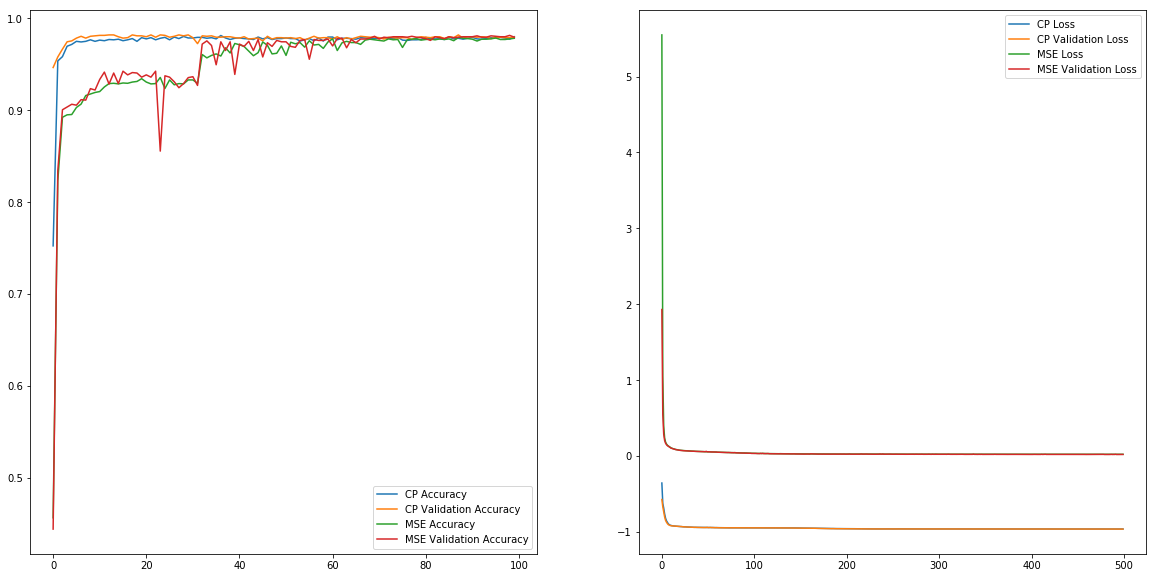

In [12]:
# accuracy etc
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.plot(NNmodel_CP_hist.history['acc'][::5], label = 'CP Accuracy')
ax.plot(NNmodel_CP_hist.history['val_acc'][::5], label = 'CP Validation Accuracy')
ax.plot(NNmodel_MSE_hist.history['acc'][::5], label = 'MSE Accuracy')
ax.plot(NNmodel_MSE_hist.history['val_acc'][::5], label = 'MSE Validation Accuracy')
ax.legend()
ax2.set_yscale('linear')
ax2.set_xscale('linear')
ax2.plot(NNmodel_CP_hist.history['loss'], label = 'CP Loss')
ax2.plot(NNmodel_CP_hist.history['val_loss'], label = 'CP Validation Loss')
ax2.plot(NNmodel_MSE_hist.history['loss'], label = 'MSE Loss')
ax2.plot(NNmodel_MSE_hist.history['val_loss'], label = 'MSE Validation Loss')
ax2.legend()

13792
[251 1014 0.032959599047899246 250 1023 0.05383110046386719 2 10]
[0.03805781 0.35512775 0.9340428 ]
vetors (true, predicted)
 [0.0186452  0.86374374 0.50358624] 
 [0.03805781 0.35512775 0.9340428 ]
cosine of angle between =  0.8456214431303513    angle =  32.26142038039197  degrees


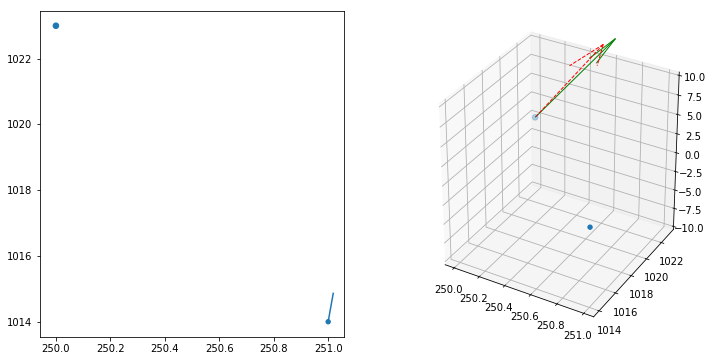

In [55]:
#individual hit, some plots
ii=30124
ii=np.random.randint(0,100000)
print(ii)
hitwewant=selectedhits[ii]
plot_a_hit(hitwewant,NNmodel_CP,1)

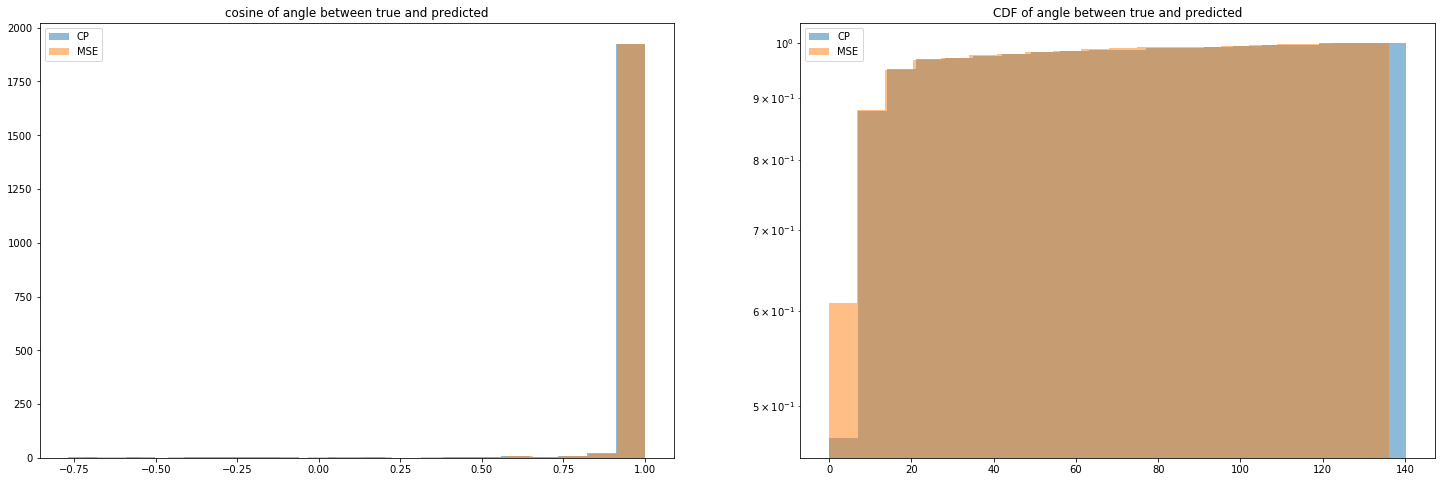

In [13]:
#(cosine of) angle between truth and prediction

    
predicteddirection_CP = predicteddirections(NNmodel_CP, x_test)
predicteddirection_MSE = predicteddirections(NNmodel_MSE, x_test)
cosines_CP=np.sum(predicteddirection_CP*y_test,axis=1)
cosines_MSE=np.sum(predicteddirection_MSE*y_test,axis=1)
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(25,8))

ax1.hist(cosines_CP,bins=20,alpha=0.5, label = 'CP')
ax1.hist(cosines_MSE,bins=20,alpha=0.5, label = 'MSE')
ax1.set_title("cosine of angle between true and predicted")
ax1.legend()
ax2.hist(np.arccos(cosines_CP)*180./np.pi,bins=20,alpha=0.5,cumulative=True,density=True, label = 'CP')
ax2.hist(np.arccos(cosines_MSE)*180./np.pi,bins=20,alpha=0.5,cumulative=True,density=True, label = 'MSE')
ax2.set_yscale("log")
ax2.set_title("CDF of angle between true and predicted")
ax2.legend()


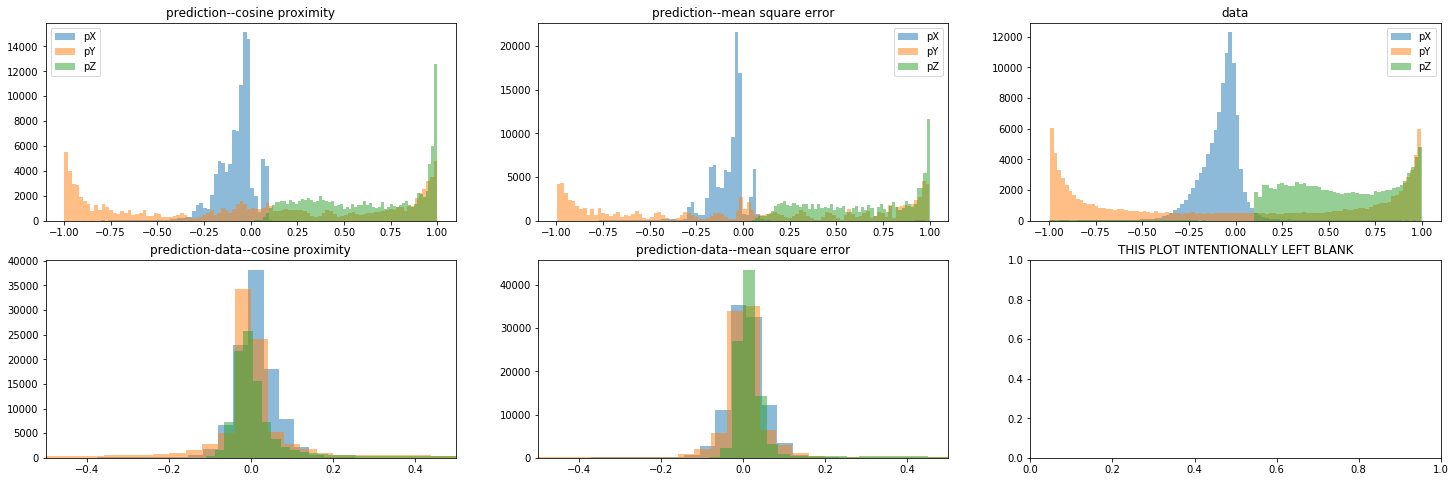

In [202]:
#comparison of data and NN predictions
fig, ax = plt.subplots(2,3,figsize=(25,8))
ax[0,0].hist(predicteddirection_CP[:,0],bins=100,alpha=0.5, label = 'pX')
ax[0,0].hist(predicteddirection_CP[:,1],bins=100,alpha=0.5, label = 'pY')
ax[0,0].hist(predicteddirection_CP[:,2],bins=100,alpha=0.5, label = 'pZ')
ax[0,0].set_title("prediction--cosine proximity")
ax[0,0].legend()
ax[0,1].hist(predicteddirection_MSE[:,0],bins=100,alpha=0.5, label = 'pX')
ax[0,1].hist(predicteddirection_MSE[:,1],bins=100,alpha=0.5, label = 'pY')
ax[0,1].hist(predicteddirection_MSE[:,2],bins=100,alpha=0.5, label = 'pZ')
ax[0,1].set_title("prediction--mean square error")
ax[0,1].legend()
ax[0,2].hist(y_test[:,0],bins=100,alpha=0.5, label = 'pX')
ax[0,2].hist(y_test[:,1],bins=100,alpha=0.5, label = 'pY')
ax[0,2].hist(y_test[:,2],bins=100,alpha=0.5, label = 'pZ')
ax[0,2].set_title("data")
ax[0,2].legend()

ax[1,0].hist(predicteddirection_CP[:,0]-y_test[:,0],bins=100,alpha=0.5)
ax[1,0].hist(predicteddirection_CP[:,1]-y_test[:,1],bins=100,alpha=0.5)
ax[1,0].hist(predicteddirection_CP[:,2]-y_test[:,2],bins=100,alpha=0.5)
ax[1,0].set_xlim(-0.5,0.5)
ax[1,0].set_title("prediction-data--cosine proximity")
ax[1,1].hist(predicteddirection_MSE[:,0]-y_test[:,0],bins=100,alpha=0.5)
ax[1,1].hist(predicteddirection_MSE[:,1]-y_test[:,1],bins=100,alpha=0.5)
ax[1,1].hist(predicteddirection_MSE[:,2]-y_test[:,2],bins=100,alpha=0.5)
ax[1,1].set_xlim(-0.5,0.5)
ax[1,1].set_title("prediction-data--mean square error")

ax[1,2].set_title("THIS PLOT INTENTIONALLY LEFT BLANK")
plt.show()


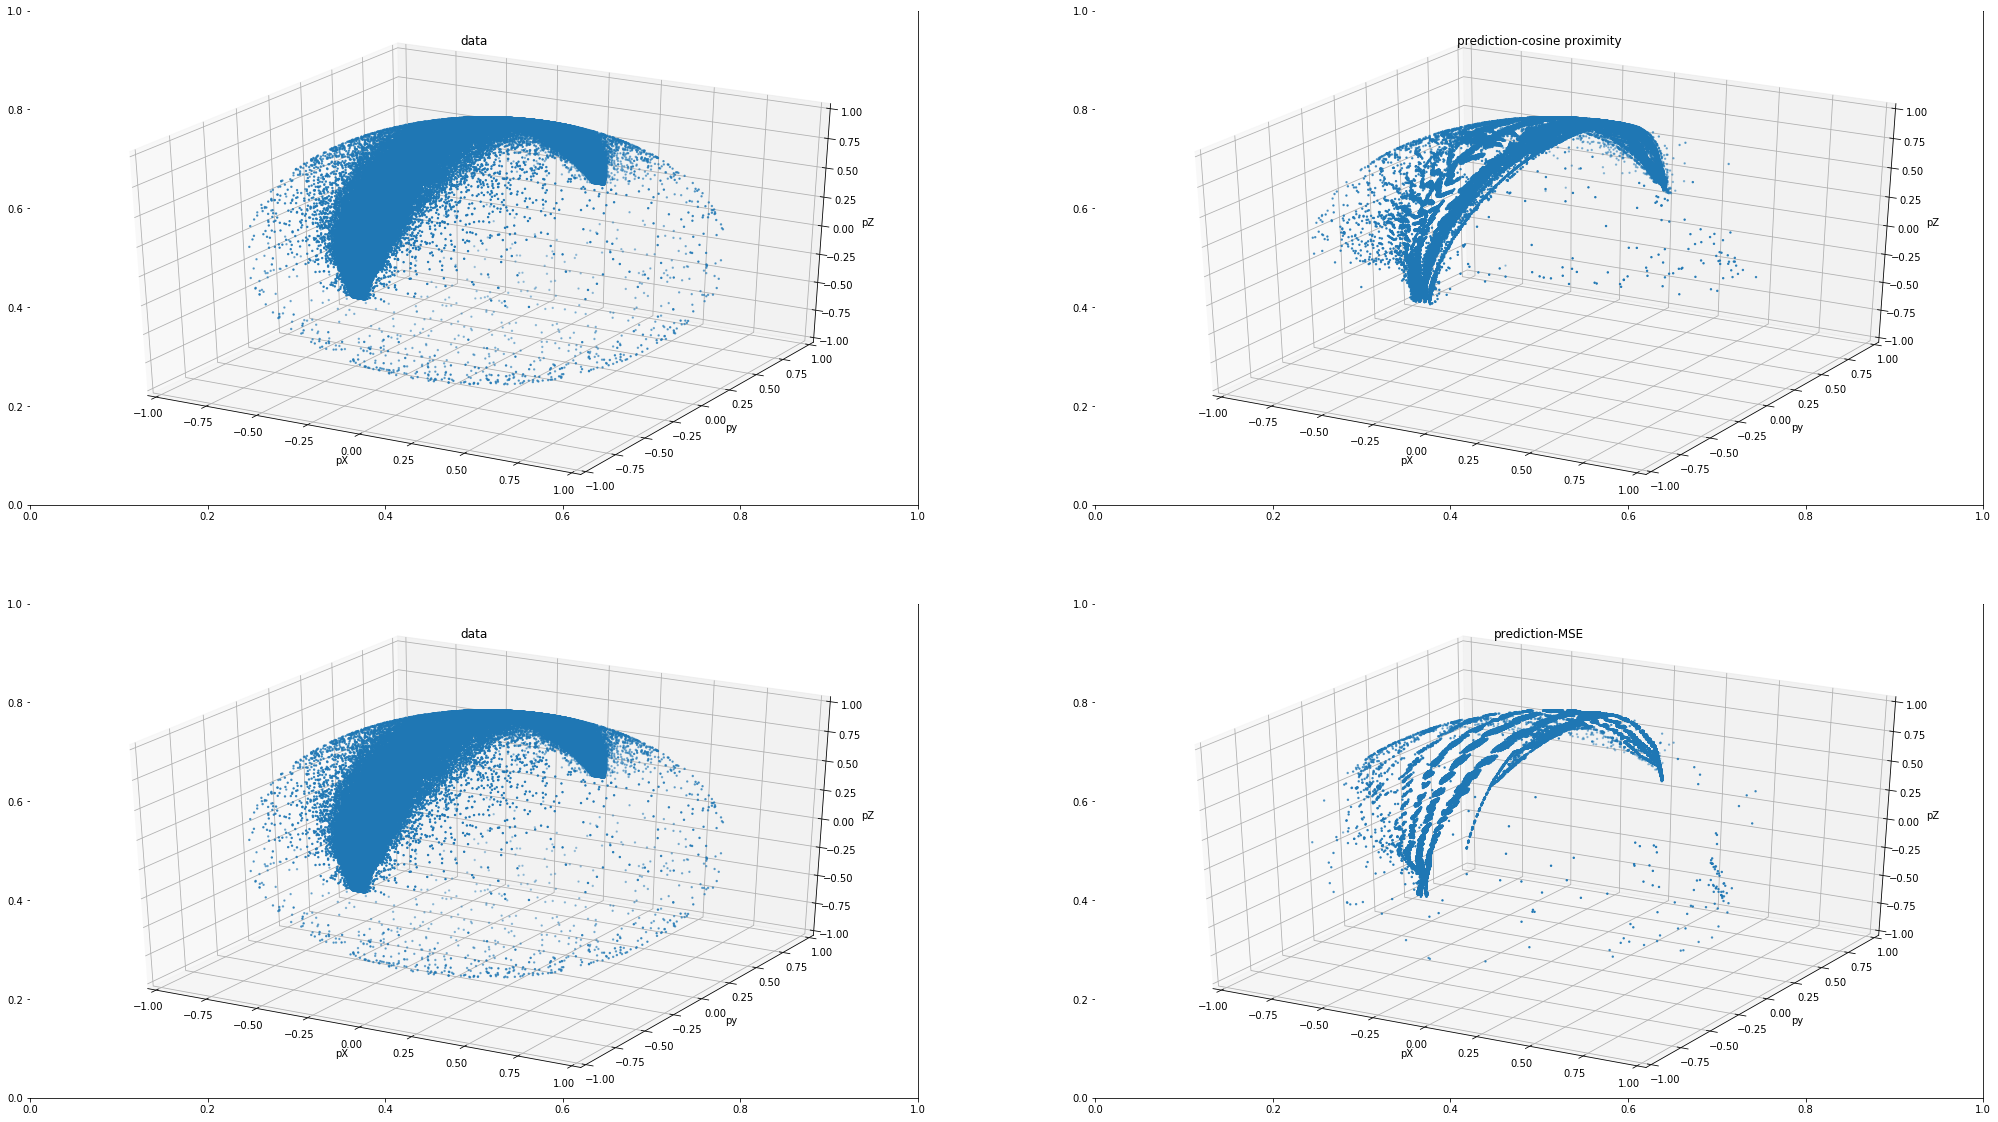

In [194]:
#where the events are located, in local coords
n_num=len(x_test)
names=["data","prediction-cosine proximity","data","prediction-MSE"]
fig, ax = plt.subplots(2,2,figsize=(35,20))
for i,data_list in zip(range(1,5),[y_test,predicteddirection_CP,y_test,predicteddirection_MSE]):
    fig.add_subplot(2,2,i,projection='3d')
    ax = fig.gca(projection='3d')
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    ax.set_title(names[i-1])
    ax.set_xlabel("pX")
    ax.set_ylabel("py")
    ax.set_zlabel("pZ")
    ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
   # ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
plt.show()


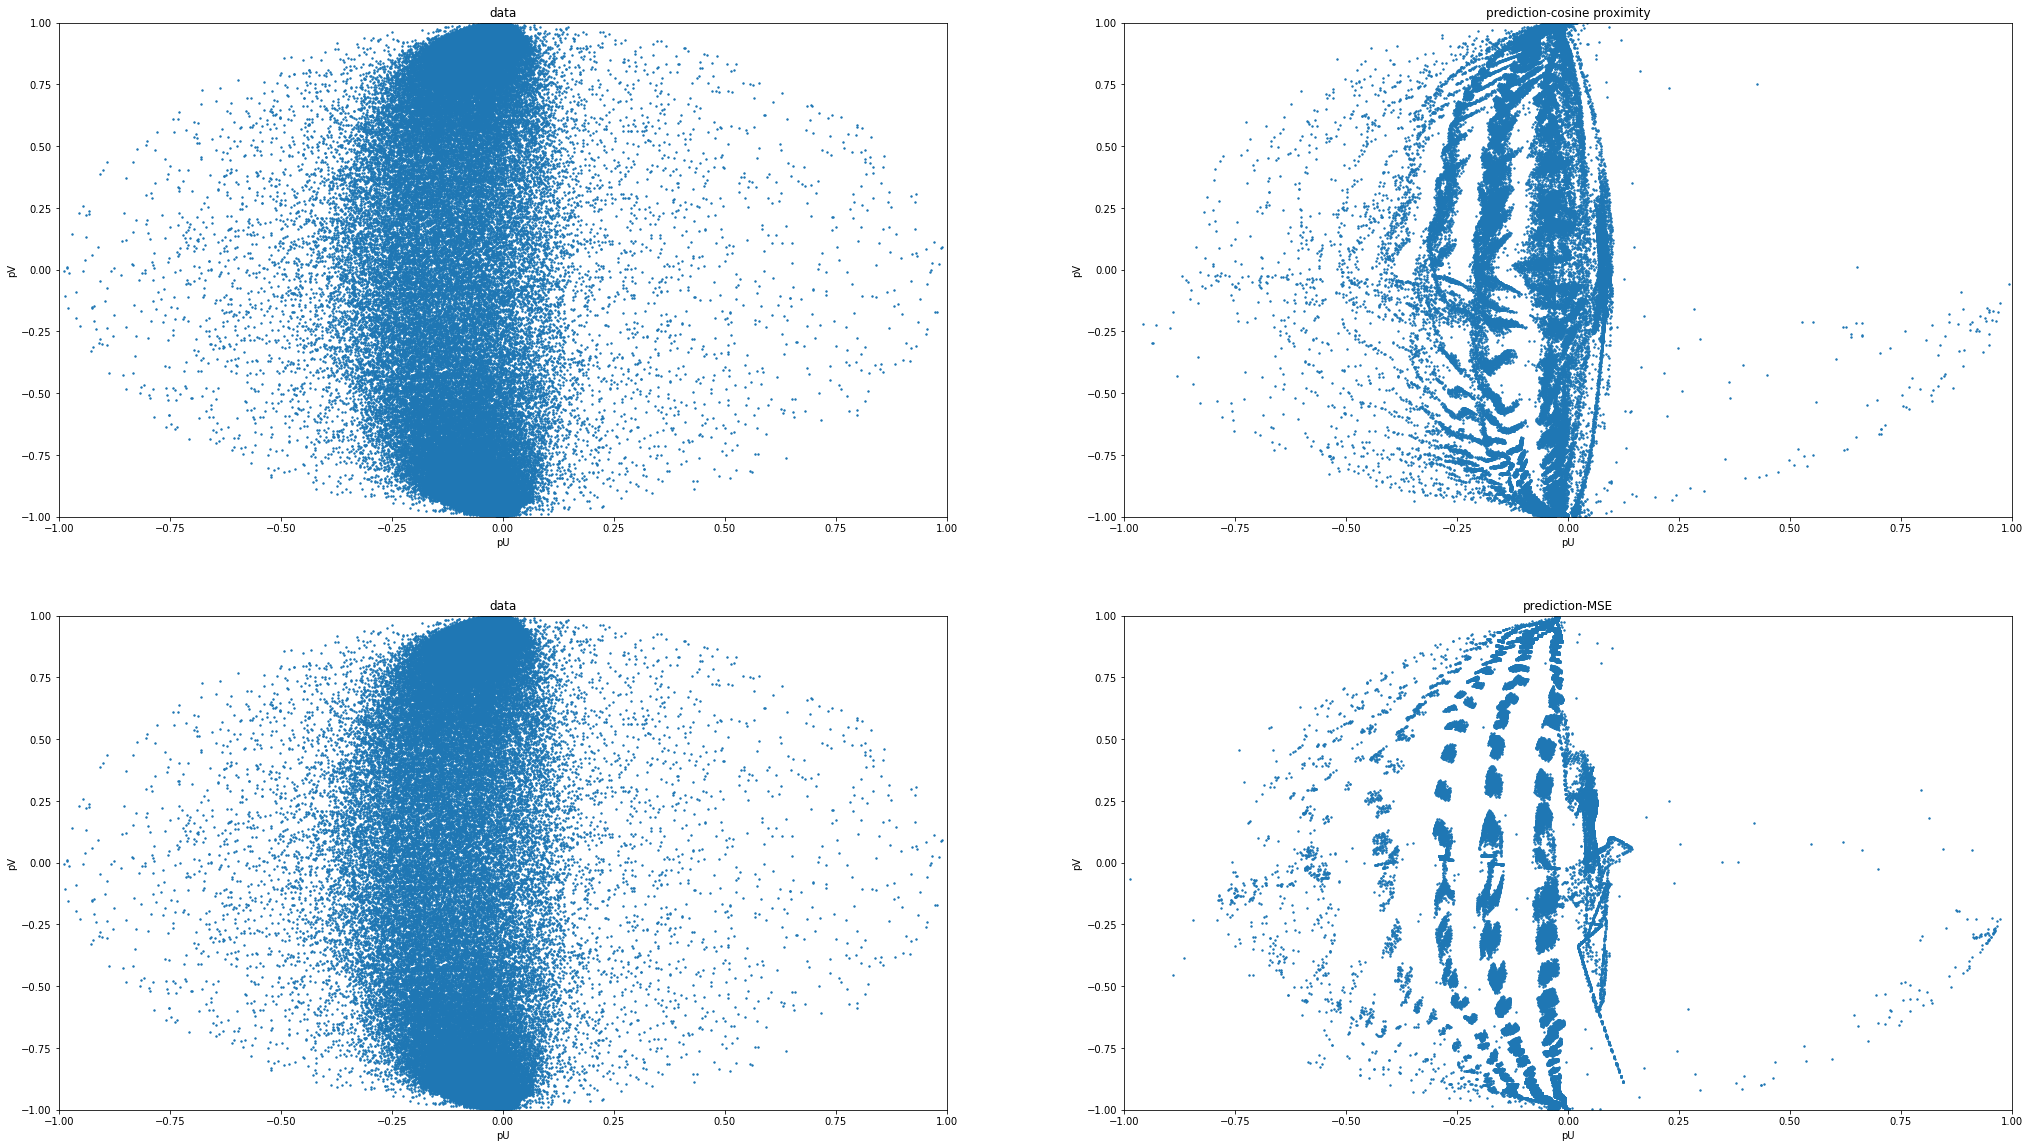

In [224]:
#where the events are located, in local coords
n_num=len(x_test)
names=["data","prediction-cosine proximity","data","prediction-MSE"]
fig=plt.figure(figsize=(35,20))
for i,data_list in zip(range(1,5),[y_test,predicteddirection_CP,y_test,predicteddirection_MSE]):
    ax = fig.add_subplot(2,2,i)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(names[i-1])
    ax.set_xlabel("pU")
    ax.set_ylabel("pV")
    ax.scatter(data_list[:n_num,0], data_list[:n_num,1],s=2)
   # ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
plt.show()



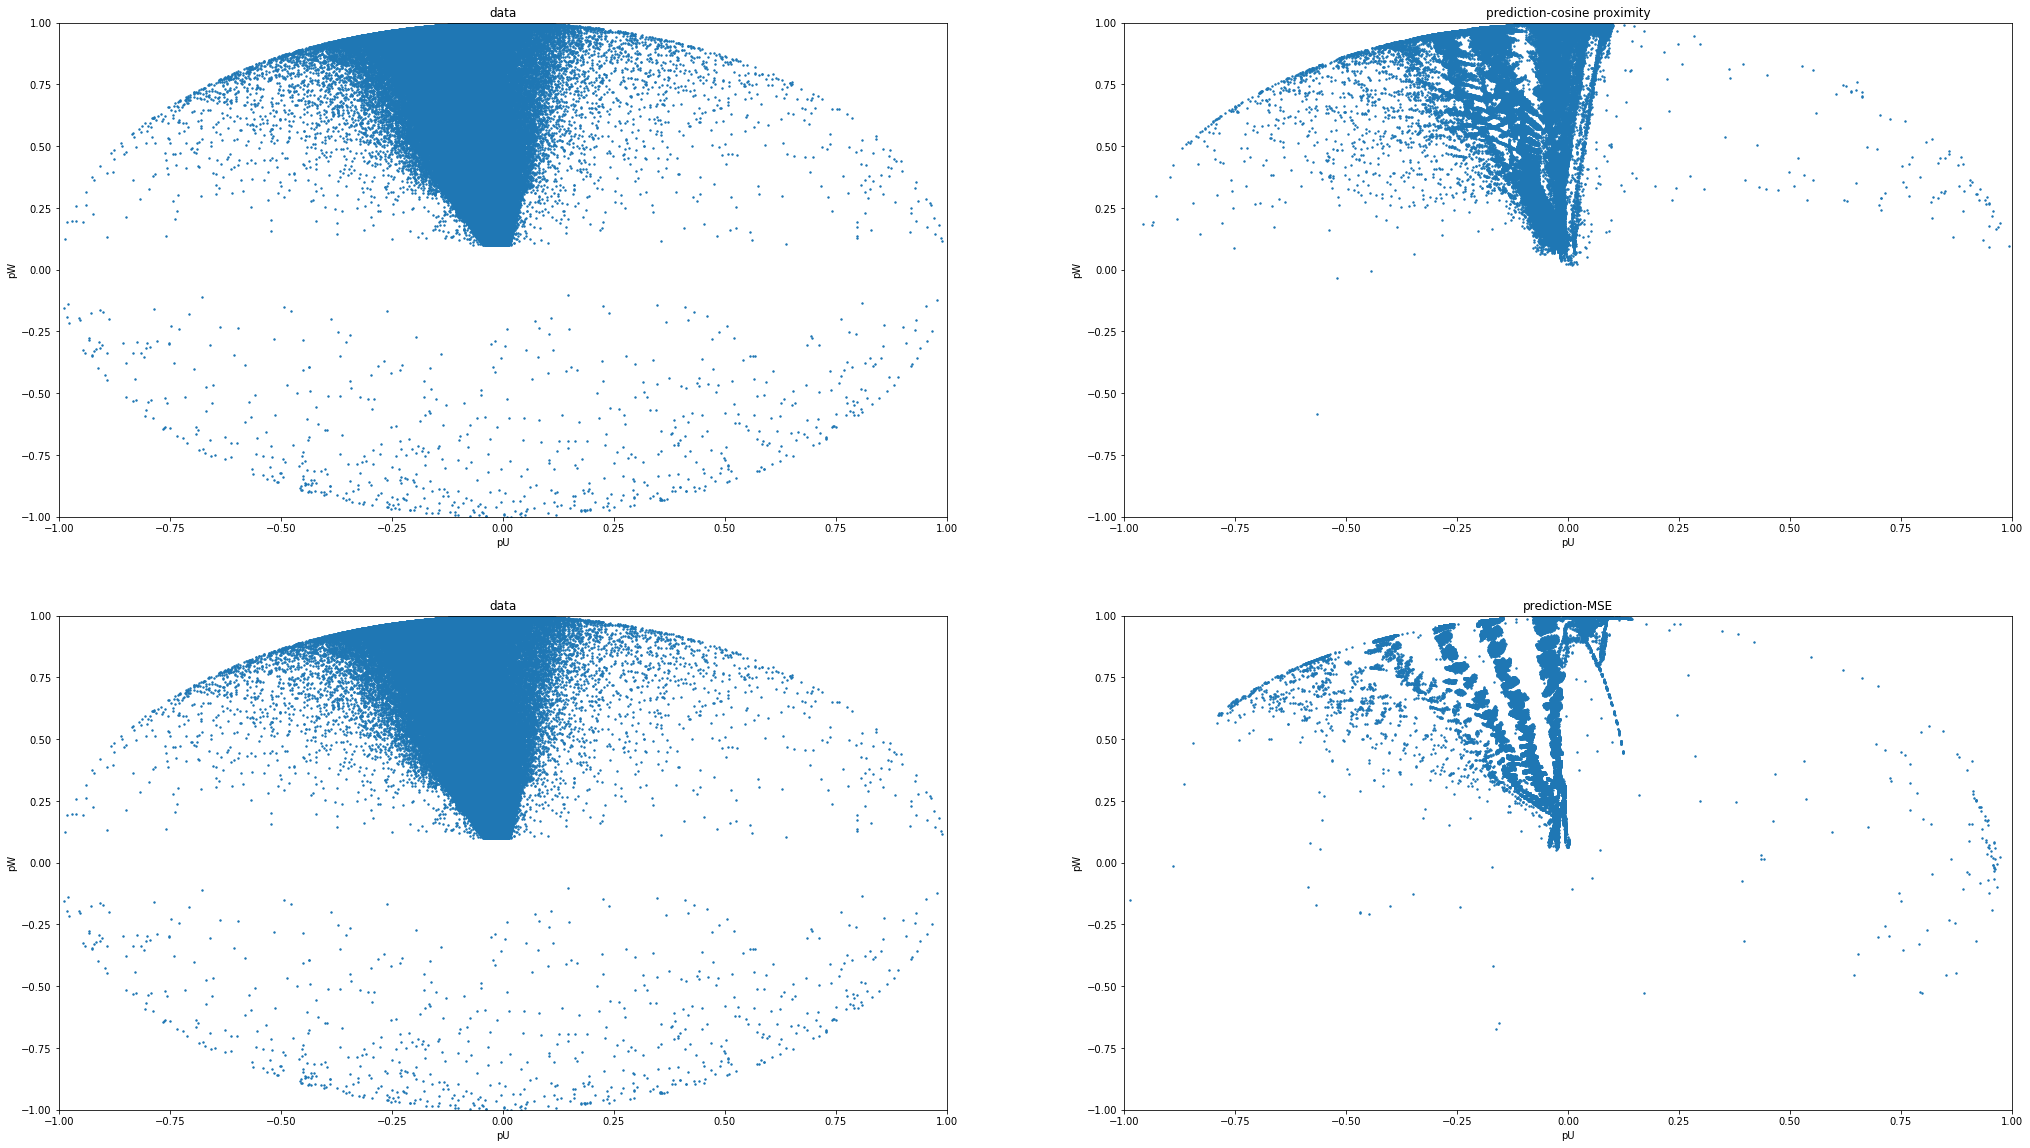

In [223]:
#where the events are located, in local coords
n_num=len(x_test)
names=["data","prediction-cosine proximity","data","prediction-MSE"]
fig=plt.figure(figsize=(35,20))
for i,data_list in zip(range(1,5),[y_test,predicteddirection_CP,y_test,predicteddirection_MSE]):
    ax = fig.add_subplot(2,2,i)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(names[i-1])
    ax.set_xlabel("pU")
    ax.set_ylabel("pW")
    ax.scatter(data_list[:n_num,0], data_list[:n_num,2],s=2)
plt.show()


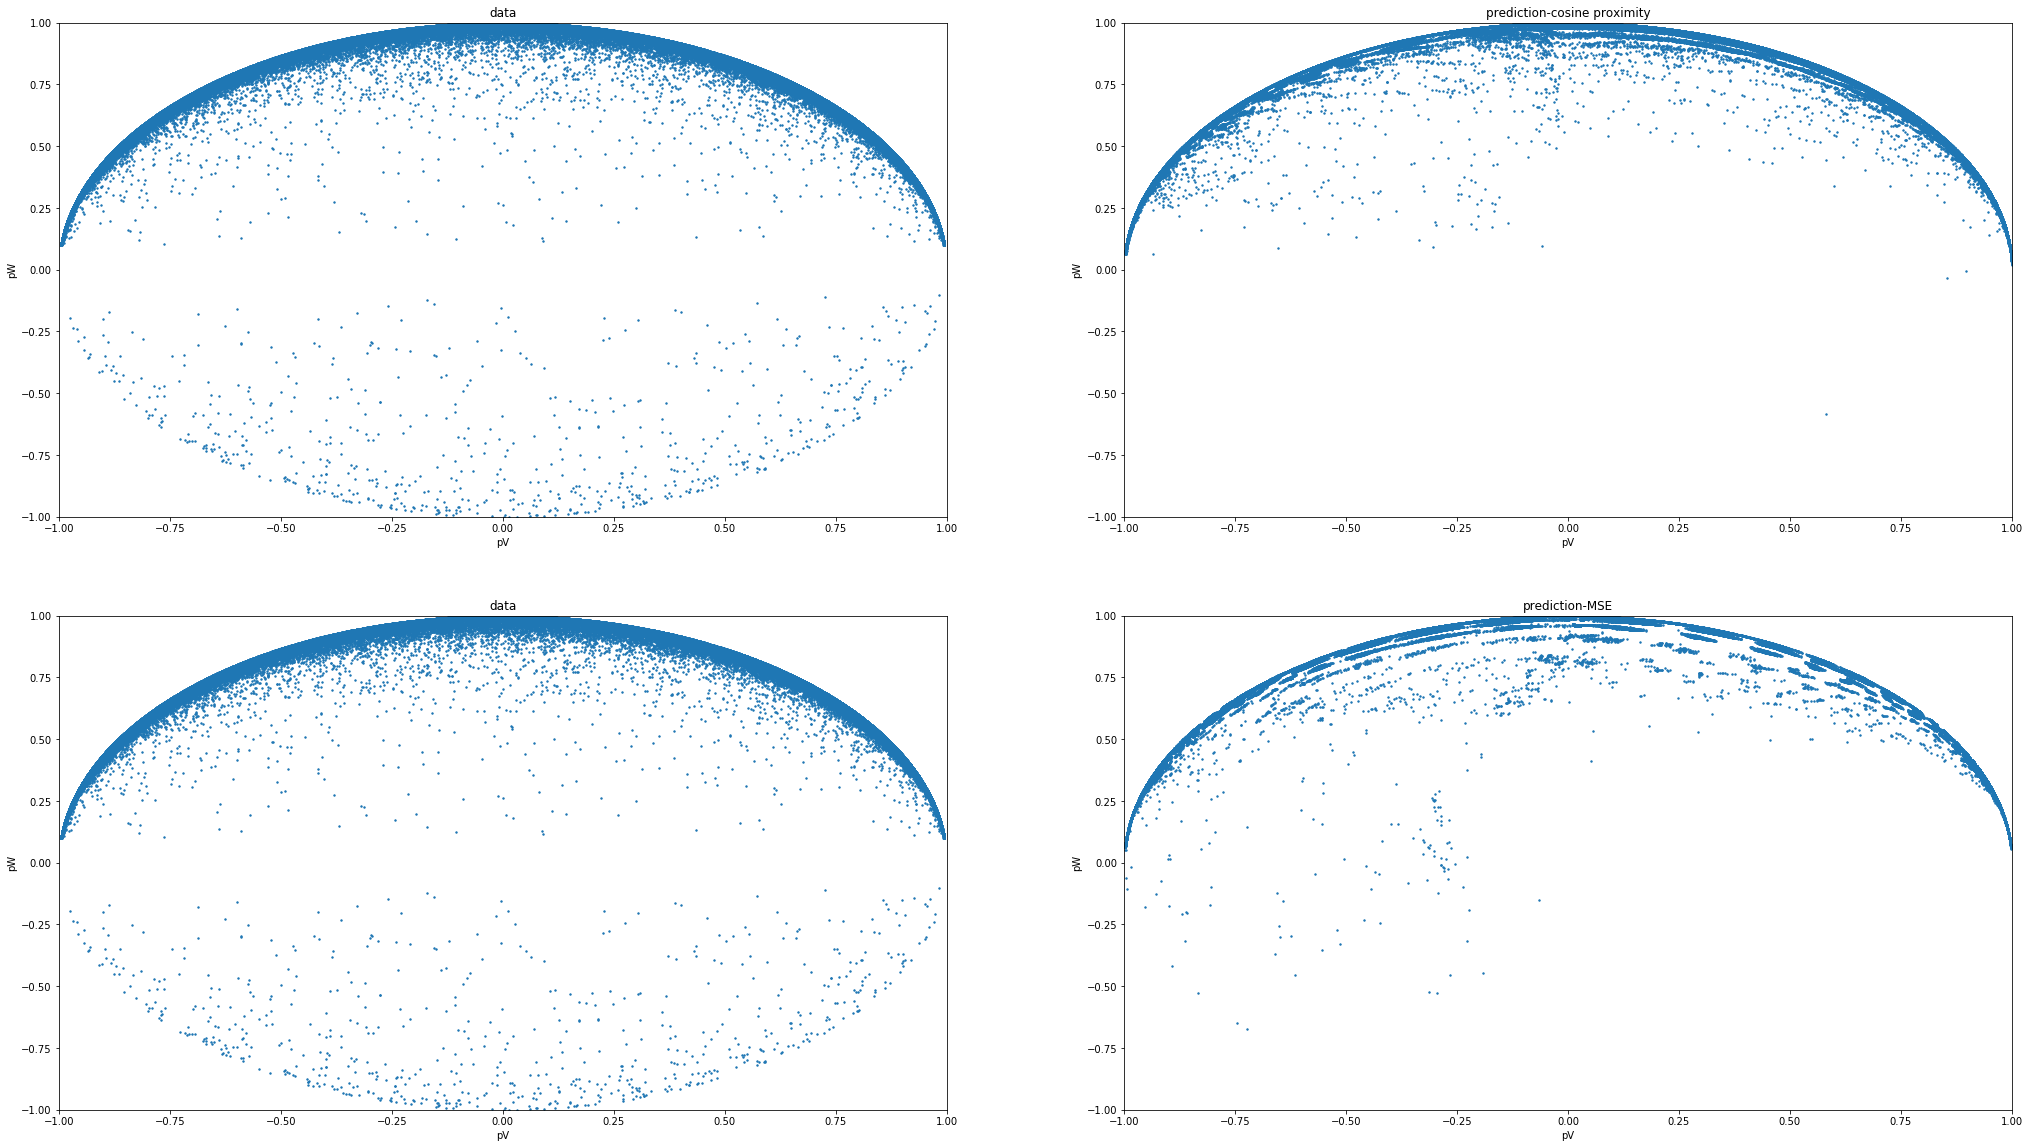

In [225]:
#where the events are located, in local coords
n_num=len(x_test)
names=["data","prediction-cosine proximity","data","prediction-MSE"]
fig=plt.figure(figsize=(35,20))
for i,data_list in zip(range(1,5),[y_test,predicteddirection_CP,y_test,predicteddirection_MSE]):
    ax=fig.add_subplot(2,2,i)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_title(names[i-1])
    ax.set_xlabel("pV")
    ax.set_ylabel("pW")
    ax.scatter(data_list[:n_num,1], data_list[:n_num,2],s=2)
   # ax.scatter(data_list[:n_num,0], data_list[:n_num,1], data_list[:n_num,2],s=2)
plt.show()

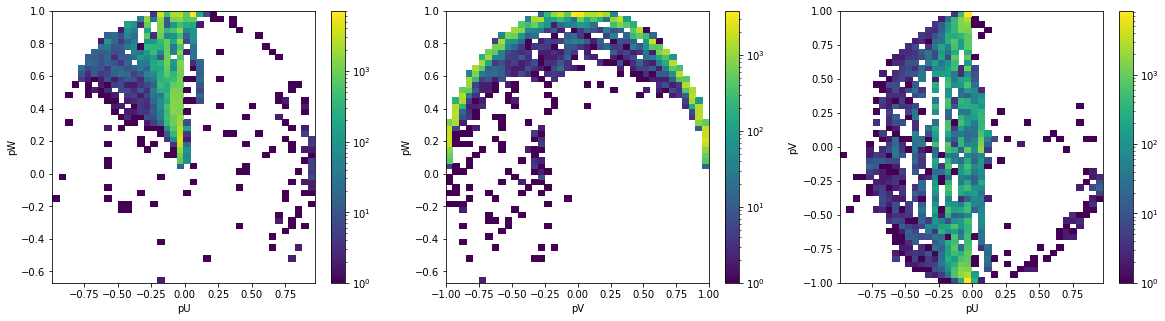

In [243]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(20,5))
temp=ax1.hist2d(data_list[:n_num,0], data_list[:n_num,2],bins=[40,50],norm=matplotlib.colors.LogNorm())
fig.colorbar(temp[3],ax=ax1)
ax1.set_xlabel("pU")
ax1.set_ylabel("pW")

temp=ax2.hist2d(data_list[:n_num,1], data_list[:n_num,2],bins=[40,50],norm=matplotlib.colors.LogNorm())
fig.colorbar(temp[3],ax=ax2)
ax2.set_xlabel("pV")
ax2.set_ylabel("pW")

temp=ax3.hist2d(data_list[:n_num,0], data_list[:n_num,1],bins=[40,50],norm=matplotlib.colors.LogNorm())
fig.colorbar(temp[3],ax=ax3)
ax3.set_xlabel("pU")
ax3.set_ylabel("pV")
plt.show()

In [204]:
###
##             NOT SO USEFUL !!!
##

#build a function that takes in hit location, vol, layer, mod, hit shape
#and returns the next layers hit location
#does this by apply NN_volid to hit shape, transforming back to global, adding on to location and 
#finding interseciton with next layer

#a helper function to find the next hit, given present hit, direction and radius of present and next layer
def find_next_hit(hitnow, direction, rnow, rnext):
    a = (direction[0]**2 + direction[1]**2) #terms in quadratic equation
    b = 2.0*(hitnow[0]*direction[0] + hitnow[1]*direction[1])
    c = rnow**2 - rnext**2
    [root1, root2] = np.roots([a,b,c])
    if np.imag(root1) > 0:
        print("no solutions for intersection")
        raise NotImplementedError
    if abs(root1) < abs(root2):
        root = root1
    else:
        root = root2
    next_hit = hitnow + root * direction
    return next_hit


#NN_choice = [NN_vol8, NN_vol13, NN_vol17]
def predict_next_hit(hitIN, NN_choice):
    '''hitIN is in form of [tx, ty, tz, volume_id, layer_id, module_id, 8 hit shape parameters]'''
    volid = hitIN[3]
    layer_id = hitIN[4]
    next_layer_id = layer_id + 2
    if next_layer_id > 8:
        print("moved out of module")
        raise NotImplementedError
    module_id = hitIN[5]
    hit_position = hitIN[:3]
    if volid == 8:
        NN_model = NN_choice[0]
    elif volid == 13:
        NN_model = NN_choice[1]
    elif volid == 17:
        NN_model = NN_choice[2]
    else:
        print("Wrong volume ID")
        raise ValueError

    detector._load_element_info(volid,layer_id,module_id)
    pos = detector.cshift
    radius_this_layer = np.sqrt(np.sum((pos*pos)[:2]))    
    detector._load_element_info(volid,next_layer_id,module_id)
    pos = detector.cshift
    radius_next_layer = np.sqrt(np.sum((pos*pos)[:2]))
    hitpattern = hitIN[-8:]
    predicteddirection_local = predicteddirections(NN_model, np.reshape(hitpattern,(1,8)))[0]
    [u ,v, w] = predicteddirection_local
    predicteddirection_global = detector.LocalToGlobalMom(u, v, w, volid,layer_id,module_id)
    #do a rotaion of this direction around y-axis by theta
    theta = math.radians(30.)
    predicteddirection_global_rot = np.array([[np.cos(theta),0,np.sin(theta)],[0,1,0],[-np.sin(theta), 0,np.cos(theta)]]).dot(predicteddirection_global)
    #solve to find where hit next layer
    #print(predicteddirection_global,predicteddirection_global_rot)
    central_hit = find_next_hit(hit_position, predicteddirection_global, radius_this_layer, radius_next_layer)
    error_hit = find_next_hit(hit_position, predicteddirection_global_rot, radius_this_layer, radius_next_layer)
    #print(hit_position,central_hit, error_hit)
    #print(radius_this_layer, radius_next_layer)
    error_radius = (error_hit-central_hit)
    error_radius = np.sqrt(np.sum(error_radius*error_radius))
    
    return(np.array(central_hit,dtype=np.float), error_radius)
        

In [312]:
#find all track lables 
all_tracks=np.unique(np.array(goodhits['particle_id']))

###function that checks if cell is inside predicted direction cone
def find_hits_in_cone(hitIN, NN_choice, cone_angle):
    '''hitIN is in form of [tx, ty, tz, volume_id, layer_id, module_id, 8 hit shape parameters]'''
    volid = hitIN[3]
    layer_id = hitIN[4]
    next_layer_id = layer_id + 2
    #print(layer_id,next_layer_id)
    if next_layer_id > 8:
        print("moved out of module")
        raise NotImplementedError
    module_id = hitIN[5]
    hit_position = hitIN[:3]
    if volid == 8:
        NN_model = NN_choice[0]
    elif volid == 13:
        NN_model = NN_choice[1]
    elif volid == 17:
        NN_model = NN_choice[2]
    else:
        print("Wrong volume ID")
        raise ValueError
    hit_location = np.array(hitIN[:3],dtype=np.float)
    print(hit_location)
    hitpattern = hitIN[-8:]
    predicteddirection_local = predicteddirections(NN_model, np.reshape(hitpattern,(1,8)))[0]
    [u ,v, w] = predicteddirection_local
    predicteddirection_global = detector.LocalToGlobalMom(u, v, w, volid,layer_id,module_id)
    possiblehits = np.array(goodhits.loc[(goodhits['volume_id'] == volid) & (goodhits['layer_id'] == next_layer_id)][['x', 'y', 'z']],dtype=np.float)
    print (predicteddirection_global)
    #print(np.linalg.norm(possiblehits-hit_location[np.newaxis,:],axis=1))
    incone = np.dot(possiblehits-hit_location,predicteddirection_global)/np.linalg.norm(possiblehits-hit_location[np.newaxis,:],axis=1) > np.cos(math.radians(cone_angle))
    return possiblehits[incone]

In [334]:
ii=5300
temp=crap[crap[:,2].argsort()][ii]
print(temp)
diff=temp-np.array([ 27.09939957,17.59869957,-52.77109909])
print(diff)
crap2=np.dot(temp-np.array([ 27.09939957,17.59869957,-52.77109909]),np.array([ 0.39324587,0.30762035,-0.86644524]))
crap2/np.linalg.norm(temp-np.array([ 27.09939957,17.59869957,-52.77109909]))

[ 47.82989883  54.05469894 -80.90450287]
[ 20.73049926  36.45599937 -28.13340378]


0.8661895194395233

In [332]:
crap=find_hits_in_cone(testhits[0],[NNmodel_CP,NNmodel_CP,NNmodel_CP],30.)
crap[crap[:,2].argsort()]

[ 27.09939957  17.59869957 -52.77109909]
[ 0.39324587  0.30762035 -0.86644524]


array([[  14.75860023,   70.10690308, -490.82000732],
       [  39.18420029,   61.84270096, -490.48498535],
       [  69.62850189,  -17.83040047, -490.47399902],
       ...,
       [  57.93270111,   43.24689865,  -76.46849823],
       [  57.20009995,   43.92060089,  -76.40110016],
       [  60.2201004 ,   38.00880051,  -76.04920197]])

22523908011851776
5
[0.3932458812078261 0.30762035743538674 -0.8664452623244038]
[ 27.09939957  17.59869957 -52.77109909]
[ 0.39324587  0.30762035 -0.86644524]
688


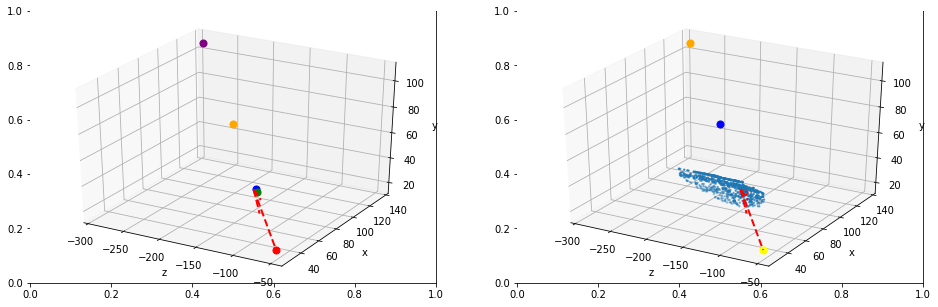

In [337]:
#pick an example track
ii=1456
track_id = all_tracks[ii]
print(track_id)
track = event.loc[(event['particle_id'] == track_id) & (event['event_id']=='1000')]
testhits = np.array(track.loc[track['volume_id'] == volid][['x', 'y', 'z', 'volume_id', 'layer_id', 'module_id', 'ch0_i', 'ch1_i', 'charge_i','ch0_f', 'ch1_f', 'charge_f', 'nch0', 'nch1']])
testhits = testhits[testhits[:,4].argsort()]
print(len(testhits))
nexthit, radius =predict_next_hit(testhits[0],[NNmodel_CP,NNmodel_CP,NNmodel_CP])
directionTEMP=nexthit-testhits[0,:3]
lengthTEMP=np.linalg.norm(directionTEMP)
print(directionTEMP/lengthTEMP)
allincone=find_hits_in_cone(testhits[0],[NNmodel_CP,NNmodel_CP,NNmodel_CP],15.)
print (len(allincone))

###plotting stuff
colors=itertools.cycle(["red", "green", "blue", "orange", "purple", "yellow"])
fig, ax = plt.subplots(1,2,figsize=(16,5))
fig.add_subplot(1,2,1,projection='3d')
ax = fig.gca(projection='3d')
ax.set_xlabel("z")
ax.set_ylabel("x")
ax.set_zlabel("y")
for i in range(len(testhits)):
    ax.scatter(testhits[i,2], testhits[i,0], testhits[i,1],s=50,color=next(colors))
#ax.scatter(possiblehits[:,0],possiblehits[:,1],possiblehits[:,2],s=1)
ax.quiver(testhits[0,2], testhits[0,0], testhits[0,1], directionTEMP[2], directionTEMP[0], directionTEMP[1], length=lengthTEMP, normalize=True, color='r',linestyle="--",linewidth=2)
fig.add_subplot(1,2,2,projection='3d')
ax = fig.gca(projection='3d')
ax.set_xlabel("z")
ax.set_ylabel("x")
ax.set_zlabel("y")
for i in range(len(testhits)):
    ax.scatter(testhits[i,2], testhits[i,0], testhits[i,1],s=50,color=next(colors))
#ax.scatter(possiblehits[:,0],possiblehits[:,1],possiblehits[:,2],s=1)
ax.quiver(testhits[0,2], testhits[0,0], testhits[0,1], directionTEMP[2], directionTEMP[0], directionTEMP[1], length=lengthTEMP, normalize=True, color='r',linestyle="--",linewidth=2)
ax.scatter(allincone[:,2], allincone[:,0], allincone[:,1],s=2)

plt.show()

In [208]:
nexthit, radius =predict_next_hit(testhits[0],[NNmodel_CP,NNmodel_CP,NNmodel_CP])
possiblehits = np.array(goodhits.loc[(goodhits['volume_id'] == testhits[0][3]) & (goodhits['layer_id'] == testhits[0][4]+2)][['x', 'y', 'z']],dtype=np.float)
incone = np.linalg.norm(possiblehits-nexthit[np.newaxis,:],axis=1) < radius
print(len(possiblehits[incone]))

53758


In [282]:
testhits

array([[-28.03809928894043, 14.238300323486328, 59.59519958496094, 8, 2,
        127, 242, 1082, 0.01933559961616993, 243, 1072,
        0.051440101116895676, 2, 11],
       [-63.948001861572266, 33.43230056762695, 136.875, 8, 4, 286, 180,
        1211, 0.05093950033187866, 181, 1201, 0.017291299998760223, 2,
        11],
       [-101.80599975585938, 54.70589828491211, 219.27000427246094, 8, 6,
        568, 286, 177, 0.03589069843292236, 285, 187,
        0.03888370096683502, 2, 11],
       [-149.67100524902344, 83.56690216064453, 325.1579895019531, 8, 8,
        930, 218, 815, 0.03956729918718338, 216, 825,
        0.04891959950327873, 3, 11]], dtype=object)

In [21]:
print(testhits[0], testhits[2])

[-21.54669952392578 -23.07200050354004 2.682569980621338 8 2 114 313 65
 0.24052700400352478 312 64 0.009414929896593094 2 2] [-50.774600982666016 -52.840301513671875 -2.403130054473877 8 4 197 53
 1219 0.013074199669063091 50 1219 0.016213400289416313 4 1]


In [27]:
testhits[:,0]

array([-27.87700080871582, -18.199600219726562, 30.455699920654297,
       70.31849670410156, -28.310300827026367, -63.08300018310547,
       -24.98430061340332, -54.1952018737793, -85.97350311279297,
       -87.4490966796875, -127.02799987792969, 4.880519866943359,
       11.13379955291748, 19.137300491333008, 29.958099365234375,
       19.484399795532227, 44.553199768066406, 72.885498046875],
      dtype=object)

In [105]:
#learn something about detector lay out
layer_layout2=np.around(np.array(event.loc[(event['volume_id'] == 8) & (event['layer_id'] == 2)][['x', 'y', 'z', 'module_id']],dtype=np.float),decimals=0)
layer_layout4=np.around(np.array(event.loc[(event['volume_id'] == 8) & (event['layer_id'] == 4)][['x', 'y', 'z', 'module_id']],dtype=np.float),decimals=0)
layer_layout6=np.around(np.array(event.loc[(event['volume_id'] == 8) & (event['layer_id'] == 6)][['x', 'y', 'z', 'module_id']],dtype=np.float),decimals=0)
layer_layout8=np.around(np.array(event.loc[(event['volume_id'] == 8) & (event['layer_id'] == 8)][['x', 'y', 'z', 'module_id']],dtype=np.float),decimals=0)

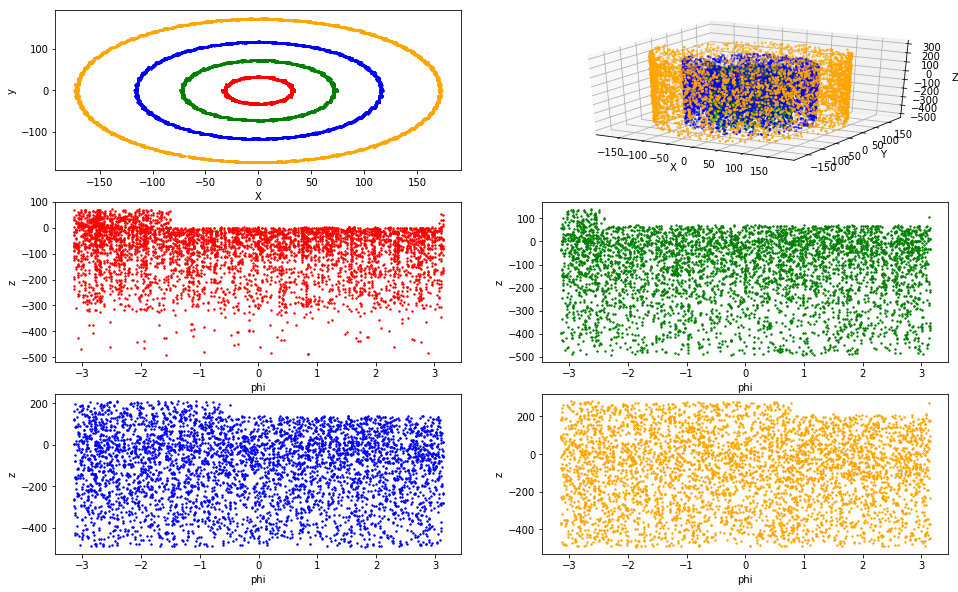

In [340]:
n_num=5000
fig=plt.figure(figsize=(16,10))
fig.add_subplot(3,2,1)
ax = fig.gca()
ax.set_xlabel("X")
ax.set_ylabel("y")
ax.scatter(layer_layout2[:n_num,0], layer_layout2[:n_num,1],s=2,c='red')
ax.scatter(layer_layout4[:n_num,0], layer_layout4[:n_num,1],s=2,c='green')
ax.scatter(layer_layout6[:n_num,0], layer_layout6[:n_num,1],s=2,c='blue')
ax.scatter(layer_layout8[:n_num,0], layer_layout8[:n_num,1],s=2,c='orange')

fig.add_subplot(3,2,2,projection='3d')
ax = fig.gca(projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.scatter(layer_layout2[:n_num,0], layer_layout2[:n_num,1], layer_layout2[:n_num,2],s=2,c='red')
ax.scatter(layer_layout4[:n_num,0], layer_layout4[:n_num,1], layer_layout4[:n_num,2],s=2,c='green')
ax.scatter(layer_layout6[:n_num,0], layer_layout6[:n_num,1], layer_layout6[:n_num,2],s=2,c='blue')
ax.scatter(layer_layout8[:n_num,0], layer_layout8[:n_num,1], layer_layout8[:n_num,2],s=2,c='orange')

fig.add_subplot(3,2,3)
ax = fig.gca()
ax.set_xlabel("phi")
ax.set_ylabel("z")
ax.scatter(np.arctan2(layer_layout2[:n_num,1],layer_layout2[:n_num,0]), layer_layout2[:n_num,2],s=2,c='red')
fig.add_subplot(3,2,4)
ax = fig.gca()
ax.set_xlabel("phi")
ax.set_ylabel("z")
ax.scatter(np.arctan2(layer_layout4[:n_num,1],layer_layout4[:n_num,0]), layer_layout4[:n_num,2],s=2,c='green')
fig.add_subplot(3,2,5)
ax = fig.gca()
ax.set_xlabel("phi")
ax.set_ylabel("z")
ax.scatter(np.arctan2(layer_layout6[:n_num,1],layer_layout6[:n_num,0]), layer_layout6[:n_num,2],s=2,c='blue')
fig.add_subplot(3,2,6)
ax = fig.gca()
ax.set_xlabel("phi")
ax.set_ylabel("z")
ax.scatter(np.arctan2(layer_layout8[:n_num,1],layer_layout8[:n_num,0]), layer_layout8[:n_num,2],s=2,c='orange')
plt.show()

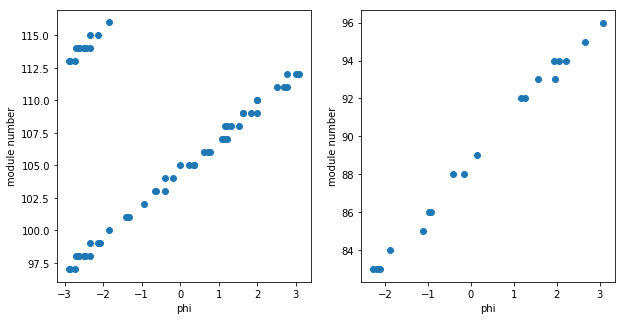

In [153]:
temp=np.array([[np.arctan2(layer_layout2[i,1],layer_layout2[i,0]), layer_layout2[i,2], layer_layout2[i,3]] for i in range(n_num)])
temp0=temp[abs(temp[:,1]) < 1][:,[0,2]]
temp2=temp[abs(temp[:,1]+100) < 1][:,[0,2]]
#temp0=temp0[:,[0,2]]
fig=plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.set_xlabel("phi")
ax.set_ylabel("module number")
ax.scatter(temp0[:,0],temp0[:,1])
ax = fig.add_subplot(1,2,2)
ax.set_xlabel("phi")
ax.set_ylabel("module number")
ax.scatter(temp2[:,0],temp2[:,1])
plt.show()

In [152]:
temp[np.abs(temp[:,1]+100) < 1]

array([[  -2.1057514 , -100.        ,   83.        ],
       [  -2.17634099, -100.        ,   83.        ],
       [  -2.26945615, -100.        ,   83.        ],
       [  -1.88283845, -100.        ,   84.        ],
       [  -1.10714872, -100.        ,   85.        ],
       [  -0.96525166, -100.        ,   86.        ],
       [  -0.92092588, -100.        ,   86.        ],
       [  -0.15991312, -100.        ,   88.        ],
       [  -0.42419441, -100.        ,   88.        ],
       [   0.15499674, -100.        ,   89.        ],
       [   1.25875421, -100.        ,   92.        ],
       [   1.17371688, -100.        ,   92.        ],
       [   1.96313647, -100.        ,   93.        ],
       [   1.57079633, -100.        ,   93.        ],
       [   2.22066678, -100.        ,   94.        ],
       [   1.929567  , -100.        ,   94.        ],
       [   2.04814171, -100.        ,   94.        ],
       [   2.64978348, -100.        ,   95.        ],
       [   3.07716581, -100.

In [85]:
np.array(layer_layout2[:3,1])

array([-3.648710012435913, -1.9347399473190308, -18.4237003326416],
      dtype=object)